# 1. Library, Env

In [3]:
import cellcharter as cc
import scvi
import matplotlib.pyplot as plt
import os
import pandas as pd
import squidpy as sq
import numpy as np
import anndata as ad
import scanpy as sc
import torch
import pickle
from matplotlib import colors
from matplotlib import cm
import dill
from squidpy.pl._color_utils import _maybe_set_colors
import warnings
warnings.filterwarnings('ignore')

sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=600, format='pdf',)
import dill
sc.settings.figdir = "/path/output"
os.chdir('/path/output/')

In [4]:
torch.backends.mps.is_available()

True

# 2. Data

In [ ]:
nanostring_dir =  "/path/raw/"
sample_dir = os.path.join(nanostring_dir, "Dismal01_Run5882")

dismal01 = sq.read.nanostring(
    path=sample_dir,
    counts_file="Dismal01_Run5882_exprMat_file.csv",
    meta_file="Dismal01_Run5882_metadata_file.csv",
    fov_file="Dismal01_Run5882_fov_positions_file.csv", 
)
dismal01.layers["counts"] = dismal01.X.copy()

meta = pd.read_csv(os.path.join(sample_dir, "Dismal01_meta.csv"))
dismal01.obs['cell_num']=dismal01.obs.index.copy()
dismal01.obs = dismal01.obs.merge(
    meta[['cell_num', 'Run_name', 'Slide_name', 'ISH.concentration', 'Commercial', 'tissue', 'slide_ID_numeric', 'Run_Tissue_name', 'log10totalcounts', 'IFcolor', 'nb_clus', 'leiden_clus', 'custom', 'nclust', 'slide_fov', 'DFS', 'OS', 'NanoString_mapping', 'id']],
    on='cell_num',
    how='left'
)

dismal01=dismal01[dismal01.obs['Run_Tissue_name'].isin(['Dismal01_Run5882'])]
dismal01.var_names_make_unique()

dismal01 = dismal01[dismal01.obs['id'].notna()]
dismal01.obs['id']=dismal01.obs['id'].astype('str')
dismal01.obs['id'] = dismal01.obs['id'].str.replace('.Run5882', '', regex=False)
dismal01.obs


meta=pd.read_csv('/path/meta/dismal1K_meta.csv',index_col=0)
meta=meta[['id','Region','region2', 'Distance.To.Border', 'Structure','celltype','major_type','minor_type','patient_id','fov_id']]
meta = meta.reset_index(drop=True)
meta['id']


dismal01.obs = dismal01.obs.merge(meta, on='id', how='left')
dismal01.var_names_make_unique()
dismal01.obs.index=dismal01.obs['id'].copy()
dismal01.obs.index.name=None
dismal01.obs

dismal01 = dismal01[dismal01.obs['minor_type'].notna()]
dismal01.obs

fov   Area  AspectRatio  CenterX_global_px  \
Dismal01_3_1       1   9529         3.47      117891.999583   
Dismal01_8_1       1  15717         2.50      117865.999583   
Dismal01_12_1      1   5870         1.22      117094.999583   
Dismal01_13_1      1  10461         0.93      116647.999583   
Dismal01_14_1      1  12309         1.75      117274.999583   
...               ..    ...          ...                ...   
Dismal01_1392_50  50   2948         1.47      188061.171799   
Dismal01_1393_50  50   5670         2.76      188581.171799   
Dismal01_1394_50  50   2836         3.22      185817.171799   
Dismal01_1395_50  50   2315         2.28      189014.171799   
Dismal01_1397_50  50   2793         2.82      188359.171799   

                  CenterY_global_px  Width  Height  Mean.PanCK  Max.PanCK  \
Dismal01_3_1           77257.271762    201      58         583       2100   
Dismal01_8_1           77214.271762    255     102         758      13052   
Dismal01_12_1          77169.271762    104      85         374       1404   
Dismal01_13_1          77146.271762    118     127         403       2103   
Dismal01_14_1          77143.271762    175     100         561       1551   
...                             ...    ...     ...         ...        ...   
Dismal01_1392_50      -77735.509028     78      53         311        688   
Dismal01_1393_50      -77734.509028    149      54         391       1191   
Dismal01_1394_50      -77743.509028    116      36         157       1131   
Dismal01_1395_50      -77741.509028     91      40         150        370   
Dismal01_1397_50      -77742.509028    107      38         290        683   

                  Mean.Empty  ...  NanoString_mapping                id  \
Dismal01_3_1             106  ...     Dismal01_08_1_1      Dismal01_3_1   
Dismal01_8_1             160  ...     Dismal01_08_1_1      Dismal01_8_1   
Dismal01_12_1             78  ...     Dismal01_08_1_1     Dismal01_12_1   
Dismal01_13_1             86  ...     Dismal01_08_1_1     Dismal01_13_1   
Dismal01_14_1            130  ...     Dismal01_08_1_1     Dismal01_14_1   
...                      ...  ...                 ...               ...   
Dismal01_1392_50         118  ...     Dismal01_01_2_4  Dismal01_1392_50   
Dismal01_1393_50         141  ...     Dismal01_01_2_4  Dismal01_1393_50   
Dismal01_1394_50          37  ...     Dismal01_01_2_4  Dismal01_1394_50   
Dismal01_1395_50          84  ...     Dismal01_01_2_4  Dismal01_1395_50   
Dismal01_1397_50         125  ...     Dismal01_01_2_4  Dismal01_1397_50   

                   Region     region2  Distance.To.Border        Structure  \
Dismal01_3_1      Outside  Non-border           39.945583          Outside   
Dismal01_8_1      Outside  Non-border           33.915660          Outside   
Dismal01_12_1     Outside  Non-border           71.587317          Outside   
Dismal01_13_1     Outside  Non-border          100.140989          Outside   
Dismal01_14_1     Outside  Non-border           50.501184          Outside   
...                   ...         ...                 ...              ...   
Dismal01_1392_50  Outside  Non-border           35.769864          Outside   
Dismal01_1393_50   Border      Border            0.000000           Border   
Dismal01_1394_50   Border      Border            0.000000           Border   
Dismal01_1395_50  Outside  Non-border           20.500693  External.margin   
Dismal01_1397_50   Border      Border            0.000000           Border   

                    major_type          minor_type patient_id  \
Dismal01_3_1                DC                 cDC       T06D   
Dismal01_8_1       Endothelial         Endothelial       T06D   
Dismal01_12_1     Plasmablasts  Plasmablasts IGHA+       T06D   
Dismal01_13_1      Endothelial         Endothelial       T06D   
Dismal01_14_1      Endothelial         Endothelial       T06D   
...                        ...                 ...        ...   
Dismal01_1392_50  Plasmablasts  Plasmablas

In [ ]:
nanostring_dir = "/path/raw/"
sample_dir = os.path.join(nanostring_dir, "Dismal03_Run5882")

dismal03 = sq.read.nanostring(
    path=sample_dir,
    counts_file="Dismal03_Run5882_exprMat_file.csv",
    meta_file="Dismal03_Run5882_metadata_file.csv",
    fov_file="Dismal03_Run5882_fov_positions_file.csv",
)
dismal03.layers["counts"] = dismal03.X.copy()

meta = pd.read_csv(os.path.join(sample_dir, "Dismal03_meta.csv"))
dismal03.obs['cell_num']=dismal03.obs.index.copy()
dismal03.obs = dismal03.obs.merge(
    meta[['cell_num', 'Run_name', 'Slide_name', 'ISH.concentration', 'Commercial', 'tissue', 'slide_ID_numeric', 'Run_Tissue_name', 'log10totalcounts', 'IFcolor', 'nb_clus', 'leiden_clus', 'custom', 'nclust', 'slide_fov', 'DFS', 'OS', 'NanoString_mapping', 'id']],
    on='cell_num',
    how='left'
)

dismal03=dismal03[dismal03.obs['Run_Tissue_name'].isin(['Dismal03_Run5882'])]
dismal03.var_names_make_unique()

dismal03 = dismal03[dismal03.obs['id'].notna()]
dismal03.obs['id']=dismal03.obs['id'].astype('str')
dismal03.obs['id'] = dismal03.obs['id'].str.replace('.Run5882', '', regex=False)
dismal03.obs


meta=pd.read_csv('/path/meta/dismal1K_meta.csv',index_col=0)
meta=meta[['id','Region','region2', 'Distance.To.Border', 'Structure','celltype','major_type','minor_type','patient_id','fov_id']]
meta = meta.reset_index(drop=True)
meta['id']


dismal03.obs = dismal03.obs.merge(meta, on='id', how='left')
dismal03.var_names_make_unique()
dismal03.obs.index=dismal03.obs['id'].copy()
dismal03.obs.index.name=None
dismal03.obs

dismal03 = dismal03[dismal03.obs['minor_type'].notna()]
dismal03.obs


fov   Area  AspectRatio  CenterX_global_px  \
Dismal03_2_1       1   5700         1.80      406222.526459   
Dismal03_3_1       1   3048         1.71      406537.526459   
Dismal03_4_1       1  12698         0.95      406661.526459   
Dismal03_5_1       1   5906         1.32      406761.526459   
Dismal03_6_1       1   4175         2.57      407576.526459   
...               ..    ...          ...                ...   
Dismal03_1017_44  44   5043         0.81      476320.952830   
Dismal03_1018_44  44   5253         0.99      477110.952830   
Dismal03_1019_44  44   4367         1.70      476749.952830   
Dismal03_1020_44  44   5677         1.95      476407.952830   
Dismal03_1021_44  44   4651         1.52      478095.952830   

                  CenterY_global_px  Width  Height  Mean.PanCK  Max.PanCK  \
Dismal03_2_1           72639.263985    126      70        1017       7710   
Dismal03_3_1           72650.263985     82      48        1215       5823   
Dismal03_4_1           72603.263985    134     141        1439      11821   
Dismal03_5_1           72635.263985    102      77        1363       9860   
Dismal03_6_1           72648.263985    131      51        2126      14418   
...                             ...    ...     ...         ...        ...   
Dismal03_1017_44      -75430.794907     79      97         366       1670   
Dismal03_1018_44      -75435.794907     87      88         262       1230   
Dismal03_1019_44      -75445.794907    117      69         216       1201   
Dismal03_1020_44      -75446.794907    129      66         413       1484   
Dismal03_1021_44      -75447.794907     97      64         738       7156   

                  Mean.Empty  ...  NanoString_mapping                id  \
Dismal03_2_1              60  ...     Dismal03_08_1_1      Dismal03_2_1   
Dismal03_3_1              59  ...     Dismal03_08_1_1      Dismal03_3_1   
Dismal03_4_1              57  ...     Dismal03_08_1_1      Dismal03_4_1   
Dismal03_5_1              66  ...     Dismal03_08_1_1      Dismal03_5_1   
Dismal03_6_1              63  ...     Dismal03_08_1_1      Dismal03_6_1   
...                      ...  ...                 ...               ...   
Dismal03_1017_44         138  ...     Dismal03_01_2_4  Dismal03_1017_44   
Dismal03_1018_44          88  ...     Dismal03_01_2_4  Dismal03_1018_44   
Dismal03_1019_44          93  ...     Dismal03_01_2_4  Dismal03_1019_44   
Dismal03_1020_44         150  ...     Dismal03_01_2_4  Dismal03_1020_44   
Dismal03_1021_44          83  ...     Dismal03_01_2_4  Dismal03_1021_44   

                   Region     region2  Distance.To.Border        Structure  \
Dismal03_2_1       Border      Border            0.000000           Border   
Dismal03_3_1       Border      Border            0.000000           Border   
Dismal03_4_1       Inside  Non-border            9.193128  Internal.margin   
Dismal03_5_1       Border      Border            0.000000           Border   
Dismal03_6_1       Border      Border            0.000000           Border   
...                   ...         ...                 ...              ...   
Dismal03_1017_44  Outside  Non-border            6.550725  External.margin   
Dismal03_1018_44  Outside  Non-border           19.373590  External.margin   
Dismal03_1019_44  Outside  Non-border           25.477614  External.margin   
Dismal03_1020_44  Outside  Non-border           17.163356  External.margin   
Dismal03_1021_44   Border      Border            0.000000           Border   

                       major_type         minor_type patient_id  \
Dismal03_2_1               Cancer    Cancer Basal SC       T01N   
Dismal03_3_1               Cancer  Cancer Unassigned       T01N   
Dismal03_4_1               Cancer     Cancer Her2 SC       T01N   
Dismal03_5_1               Cancer  Cancer Unassigned       T01N   
Dismal03_6_1               Cancer    Cancer Basal SC       T01N   
...                           ...                ...        ...   
Dismal03_1017_44            

In [5]:
dismal03.obs.index=dismal03.obs['id'].copy()
dismal03.obs.index.name=None
dismal01.obs.index=dismal01.obs['id'].copy()
dismal01.obs.index.name=None
dismal03.obs['library_id']='dismal03'
dismal01.obs['library_id']='dismal01'

In [6]:
adata_list = []
adata_list.append(dismal01)
adata_list.append(dismal03)
adata_list

[AnnData object with n_obs × n_vars = 64670 × 1010
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.Empty', 'Max.Empty', 'Mean.MembraneStain_B2M', 'Max.MembraneStain_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'cell_num', 'Run_name', 'Slide_name', 'ISH.concentration', 'Commercial', 'tissue', 'slide_ID_numeric', 'Run_Tissue_name', 'log10totalcounts', 'IFcolor', 'nb_clus', 'leiden_clus', 'custom', 'nclust', 'slide_fov', 'DFS', 'OS', 'NanoString_mapping', 'id', 'Region', 'region2', 'Distance.To.Border', 'Structure', 'major_type', 'minor_type', 'patient_id', 'fov_id', 'library_id'
     uns: 'spatial'
     obsm: 'spatial', 'spatial_fov'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 62671 × 1010
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.Empty', 'Max.Empty', 'Mean.MembraneStain_B2M

In [7]:
data = ad.concat(adata_list, axis=0, merge='same', pairwise=True, index_unique='_')
data

AnnData object with n_obs × n_vars = 127341 × 1010
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.Empty', 'Max.Empty', 'Mean.MembraneStain_B2M', 'Max.MembraneStain_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'cell_num', 'Run_name', 'Slide_name', 'ISH.concentration', 'Commercial', 'tissue', 'slide_ID_numeric', 'Run_Tissue_name', 'log10totalcounts', 'IFcolor', 'nb_clus', 'leiden_clus', 'custom', 'nclust', 'slide_fov', 'DFS', 'OS', 'NanoString_mapping', 'id', 'Region', 'region2', 'Distance.To.Border', 'Structure', 'major_type', 'minor_type', 'patient_id', 'fov_id', 'library_id'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [8]:
data.uns['spatial_fov'] = {sample: data[data.obs['fov_id'] == sample].obs[['CenterY_global_px', 'CenterX_global_px']].values.tolist() for sample in data.obs['fov_id'].unique()}
data.uns['spatial_fov']

{'Dismal01_1_1_FOV1': [[77257.2717615763, 117891.999582926],
  [77214.2717615763, 117865.999582926],
  [77169.2717615763, 117094.999582926],
  [77146.2717615763, 116647.999582926],
  [77143.2717615763, 117274.999582926],
  [77131.2717615764, 116986.999582926],
  [77134.2717615763, 117779.999582926],
  [77086.2717615764, 119191.999582926],
  [77068.2717615764, 116903.999582926],
  [77028.2717615763, 118085.999582926],
  [77002.2717615763, 119238.999582926],
  [77020.2717615763, 116801.999582926],
  [77009.2717615764, 116108.999582926],
  [76972.2717615763, 117719.999582926],
  [76963.2717615763, 117988.999582926],
  [76958.2717615763, 117652.999582926],
  [76936.2717615763, 117860.999582926],
  [76917.2717615763, 116136.999582926],
  [76863.2717615763, 117067.999582926],
  [76853.2717615763, 116827.999582926],
  [76867.2717615763, 117623.999582926],
  [76857.2717615763, 116733.999582926],
  [76839.2717615763, 117449.999582926],
  [76828.2717615763, 117870.999582926],
  [76818.2717615763

In [10]:
cluster_order=['Non-dismal','Dismal']
data.obs['DFS']=data.obs['DFS'].astype('str')
data.obs['DFS'] = np.where(data.obs['DFS'] == '0.0', 'Dismal', 'Non-dismal')
data.obs['DFS']=data.obs['DFS'].astype('category')

data.obs['DFS']=data.obs['DFS'].cat.reorder_categories(cluster_order)
data.obs['DFS'].value_counts()

DFS
Non-dismal    89890
Dismal        37451
Name: count, dtype: int64

In [23]:
data.layers["counts"] = data.X.copy()

sc.pp.normalize_total(data, target_sum=1e6)
sc.pp.log1p(data)

In [24]:
data = data.copy()

# 3. Batch correction

In [25]:
scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    data, 
    layer="counts", 
    batch_key='fov_id'
)

model = scvi.model.SCVI(data)

Global seed set to 12345


In [27]:
device = torch.device("mps")

model.train(early_stopping=True, enable_progress_bar=True,use_gpu=False)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 68/68: 100%|██████████| 68/68 [29:13<00:00, 18.87s/it, v_num=1, train_loss_step=581, train_loss_epoch=343]    

`Trainer.fit` stopped: `max_epochs=68` reached.


Epoch 68/68: 100%|██████████| 68/68 [29:13<00:00, 25.79s/it, v_num=1, train_loss_step=581, train_loss_epoch=343]


In [28]:
data.obsm['X_scVI'] = model.get_latent_representation(data).astype(np.float32)


In [29]:
data.obs['fov_id']=data.obs['fov_id'].astype('category')
sq.gr.spatial_neighbors(data, library_key='fov_id', coord_type='generic', delaunay=True, spatial_key='spatial_fov')
cc.gr.remove_long_links(data)

# 4. Autok

In [31]:
autok = cc.tl.ClusterAutoK(
    n_clusters=(2,25), 
    max_runs=30, 
    model_params=dict(
        random_state=12345
        # If running on GPU
        #trainer_params=dict(accelerator='gpu', devices=1)
    )
)

In [32]:
autok.fit(data, use_rep='X_cellcharter')

Iteration 1/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 2/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 3/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 4/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 5/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 6/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 7/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 8/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 9/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 10/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Iteration 11/15


  0%|          | 0/26 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` rea

Convergence with a change in stability of 0.009758508012837388 reached after 11 iterations


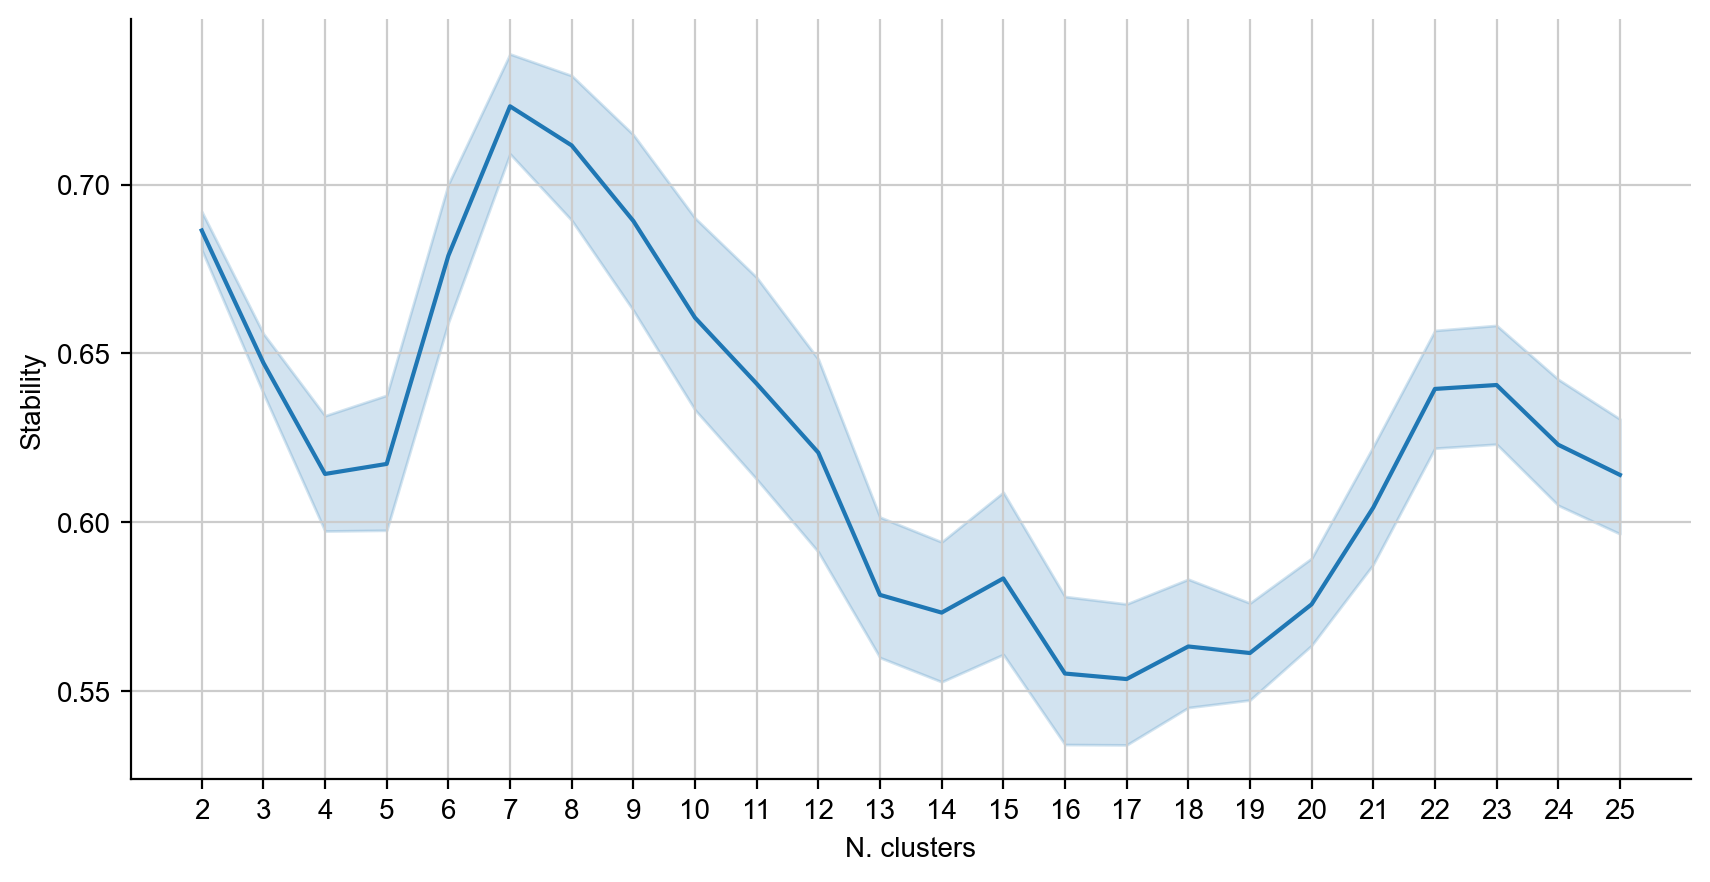

In [5]:
import matplotlib.pyplot as plt

# Your existing code to generate the plot
ax = cc.pl.autok_stability(autok, save=None, return_ax=True)

# Set the size of the figure
fig = ax.figure
fig.set_size_inches(10, 5)

# Save the figure as a PDF
fig.savefig('autook_stability_cosmx1K.pdf')


In [55]:
data.obs['cellcharter_7'] = autok.predict(data, use_rep='X_cellcharter',k=7)
data.obs['cellcharter_2'] = autok.predict(data, use_rep='X_cellcharter',k=2)
data.obs['cellcharter_5'] = autok.predict(data, use_rep='X_cellcharter',k=5)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [56]:
data.obs['cellcharter_5']=data.obs['cellcharter_5'].astype('str')
data.obs['cellcharter_7']=data.obs['cellcharter_7'].astype('str')
data.obs['cellcharter_2']=data.obs['cellcharter_2'].astype('str')

In [57]:
data.obs['cellcharter_7t']='T'+data.obs['cellcharter_7']
data.obs['cellcharter_2t']='T'+data.obs['cellcharter_2']
data.obs['cellcharter_7']=data.obs['cellcharter_7'].astype('category')
data.obs['cellcharter_2']=data.obs['cellcharter_2'].astype('category')
data.obs['cellcharter_7t']=data.obs['cellcharter_7t'].astype('category')
data.obs['cellcharter_2t']=data.obs['cellcharter_2t'].astype('category')


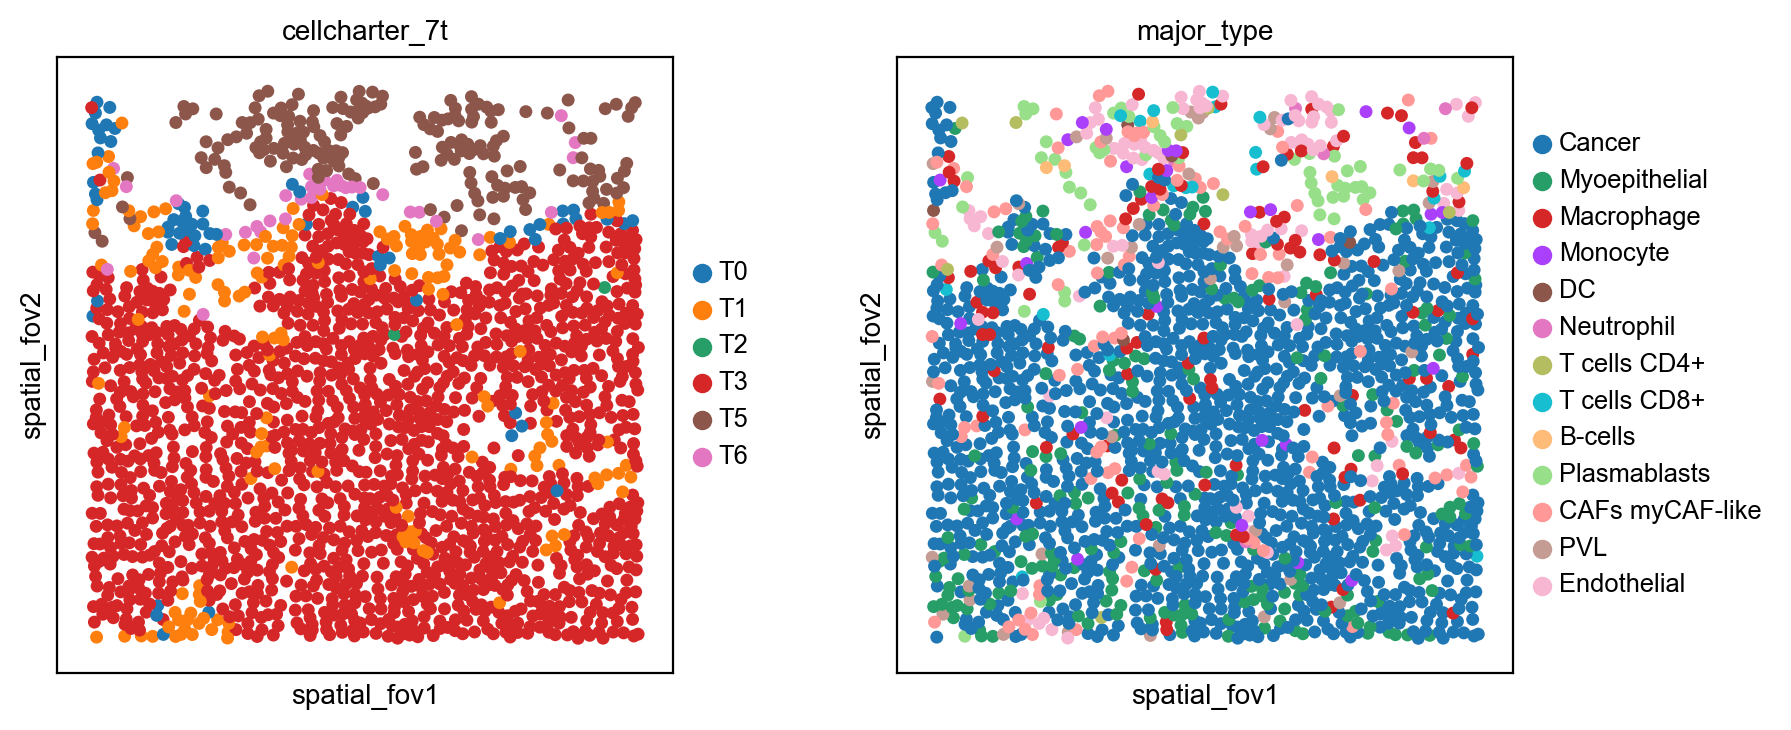

In [80]:
sq.pl.spatial_scatter(
    data, 
    color=['cellcharter_7t','major_type'], 
    library_key='fov_id',  
    size=50, 
    img=None,
    spatial_key='spatial_fov', 
    figsize=(4,4),
    ncols=2,    
    library_id=['Dismal01_1_4_FOV39'],
)

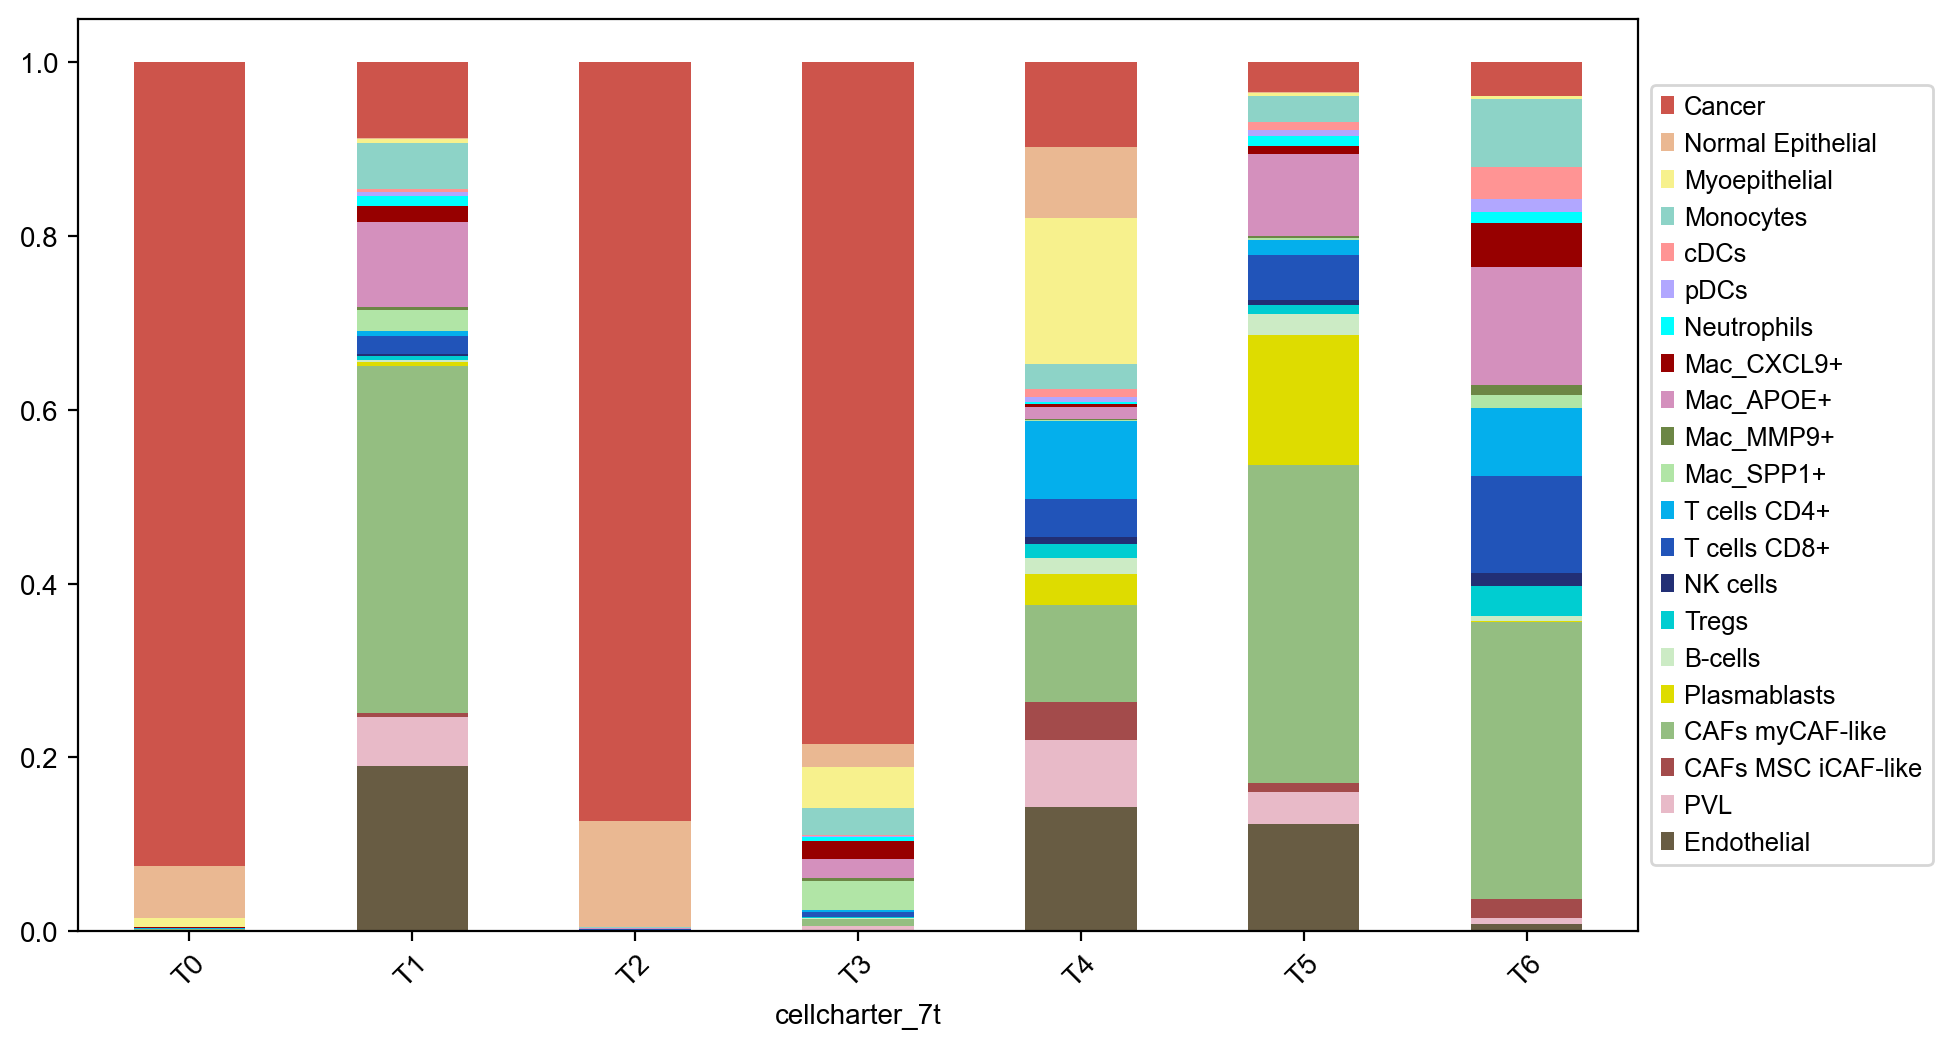

In [14]:
# Iterate over unique values of 'DFS'
for value in data.obs['DFS'].unique():
    # Select the subset of data corresponding to the current DFS value
    subset = data[data.obs['DFS'] == value]
    
    # Create a proportion plot for the subset
    cc.pl.proportion(
        subset,
        group_key='cellcharter_7t',  # Column in 'obs' that defines the groups
        label_key='celltype',        # Column in 'obs' that defines the cell types
        figsize=(10, 6),
        palette=celltype_colors       # Dictionary mapping cell types to colors
    )
    
    # Add a title to the plot
    plt.title(f'DFS: {value}')
    
    # Save the plot if needed (uncomment the line below)
    # plt.savefig(f'cellcharter8_proportion_celltype_{value}.pdf')
    
    # Display the plot
    plt.show()

In [ ]:
pd.crosstab(data.obs['major_type'],data.obs['cluster_cellcharter'])

# 5. Cell type enrichment

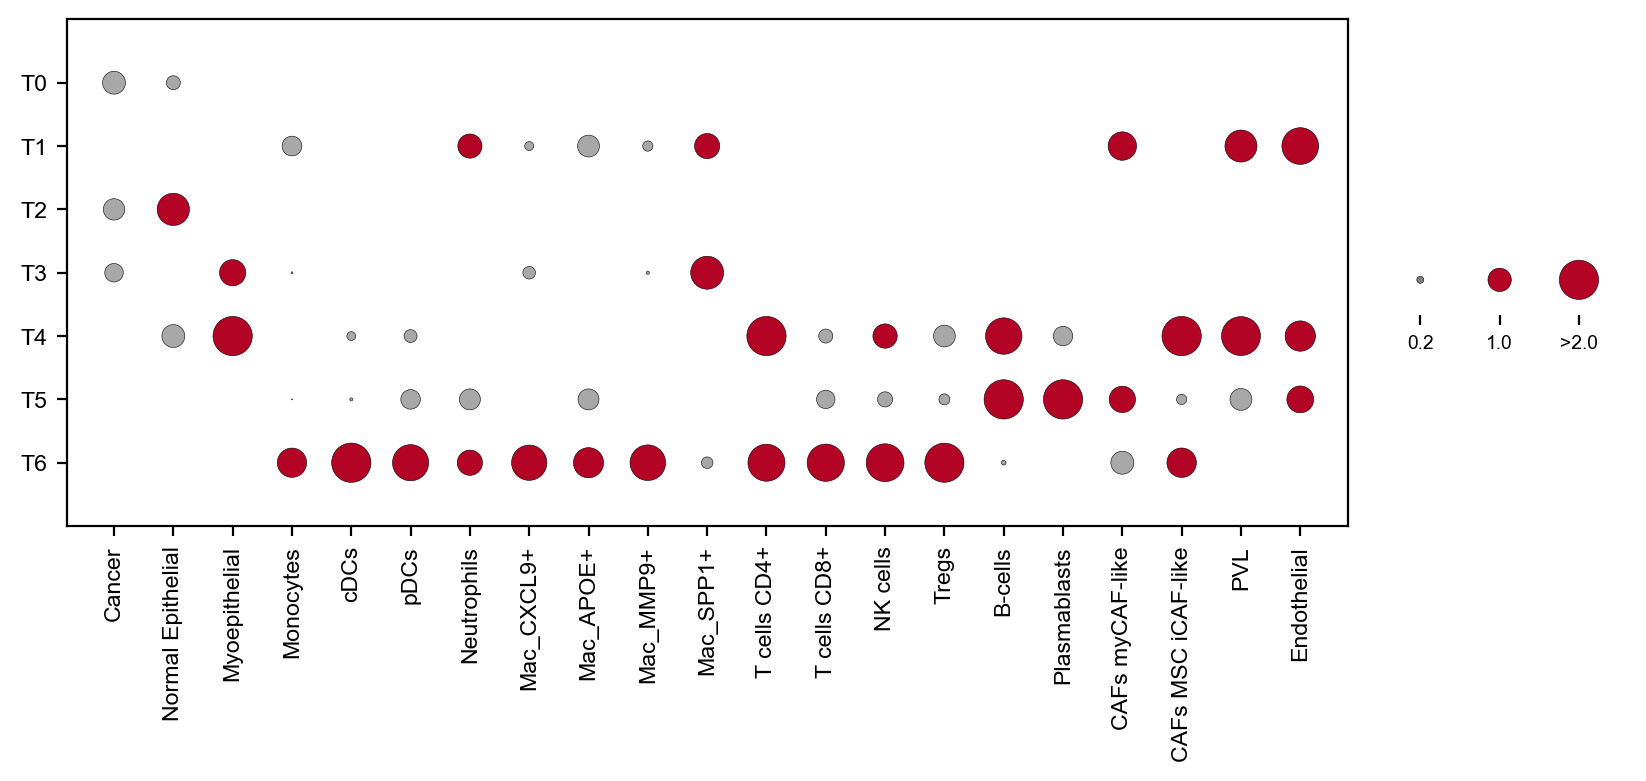

In [44]:
cc.gr.enrichment(data, group_key='celltype', label_key='cellcharter_7t')
cc.pl.enrichment(data, group_key='celltype', label_key='cellcharter_7t', color_threshold=1, size_threshold=2,
                 cluster_labels=False,
                 save='Dismal1K_cellcharter_7t_celltype_enrichment.pdf')

# 7. Neighborhood

# 7-1. Neighborhood by cellcharter

In [42]:
niche_colors=['#767F8FFF','#F0E990FF','#52838CFF','#366698FF','#DB9CABFF','#F0E990FF','#D9822FFF']
niche_palette = plt.cm.colors.ListedColormap(niche_colors)

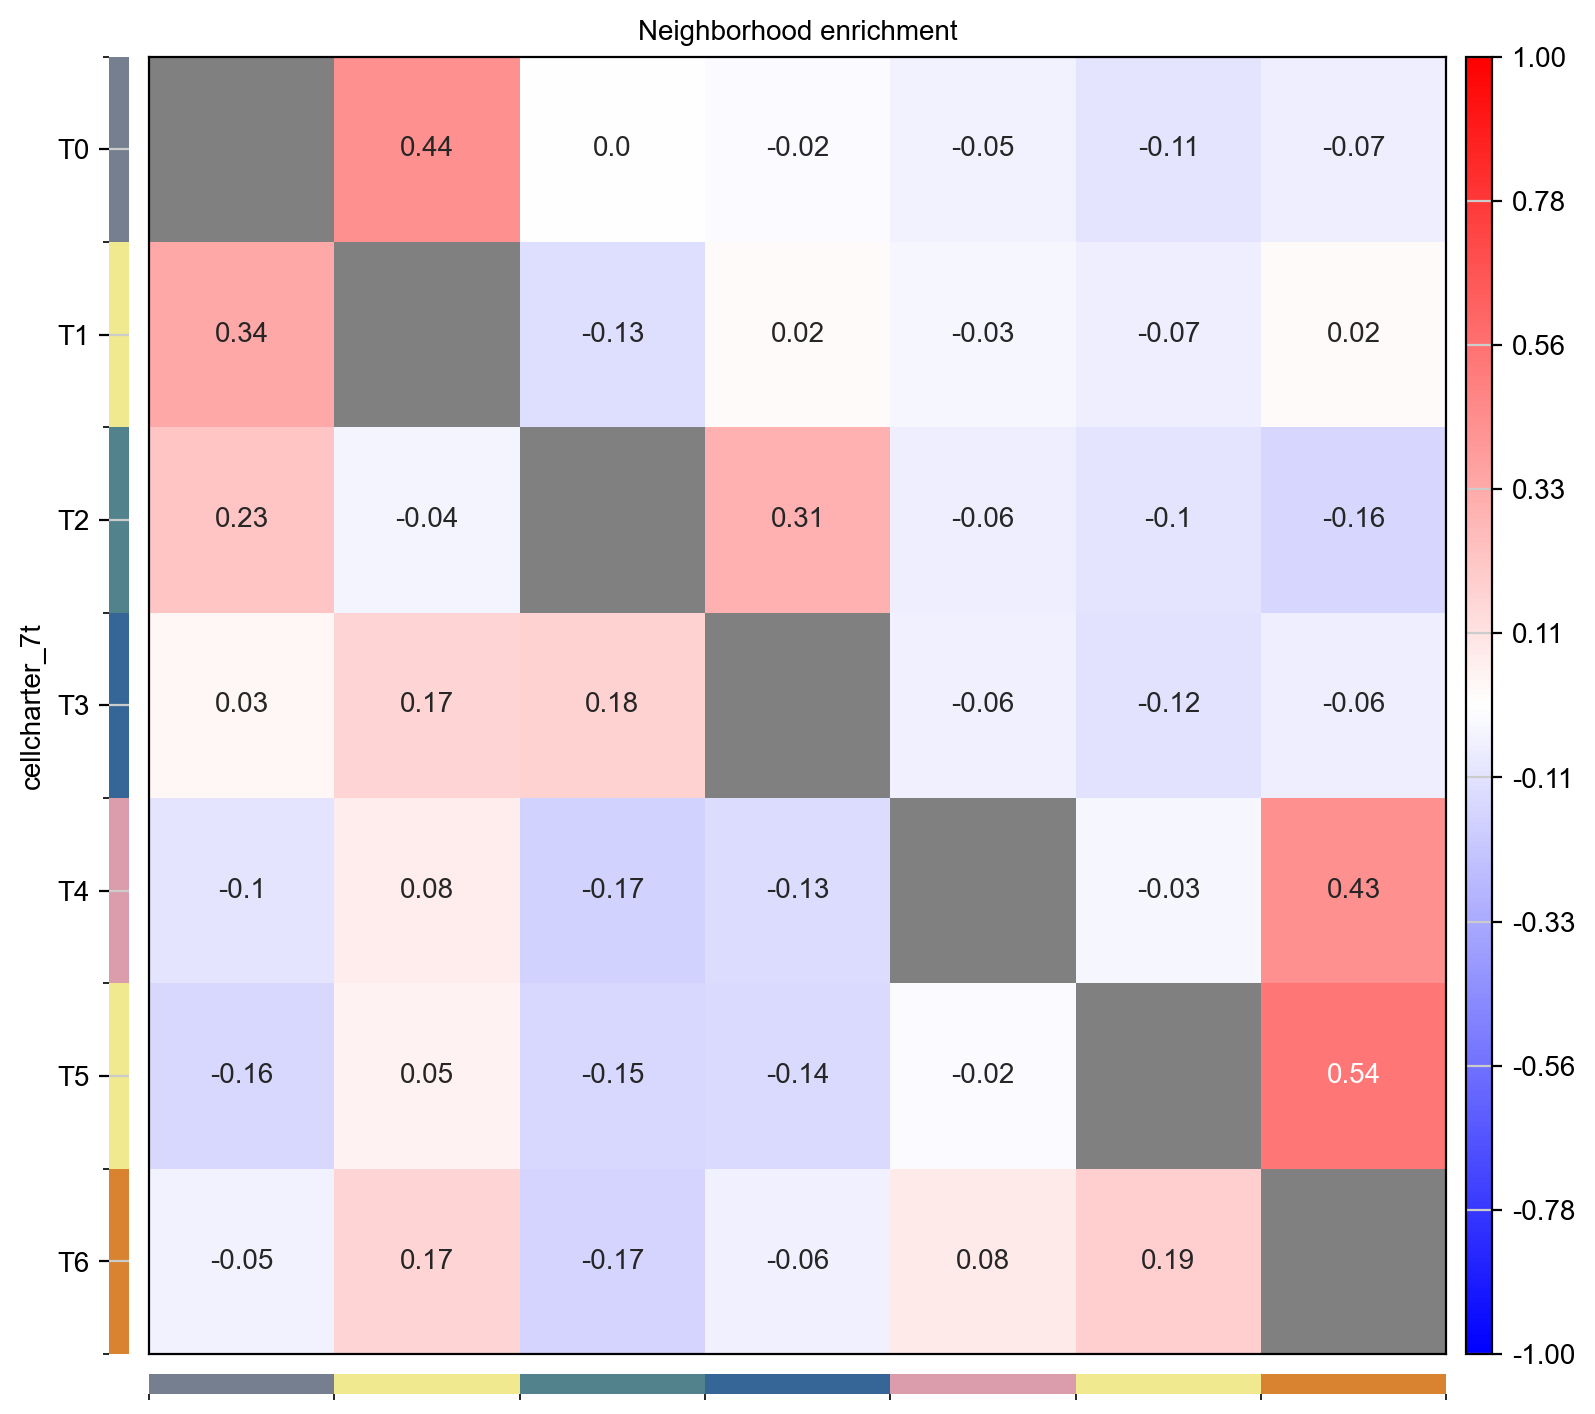

In [296]:
cc.gr.nhood_enrichment(
    data,
    cluster_key='cellcharter_7t',
)

cc.pl.nhood_enrichment(
    data,
    cluster_key='cellcharter_7t',
    annotate=True,
    palette=niche_palette,
    vmin=-1,
    vmax=1,
    save='overall_neighbor_charter_cluster.pdf'
)

In [117]:
cc.gr.diff_nhood_enrichment(
    data,
    cluster_key='cellcharter_7t',
    condition_key='DFS',
    library_key='fov_id',
    pvalues=True,
    n_jobs=15,
    n_perms=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/eunseopseo/opt/anaconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/eunseopseo/opt/anaconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/eunseopseo/opt/anaconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:122: FutureWarning: Series.__getitem__ treating k

# 7-2. Neighbor diff

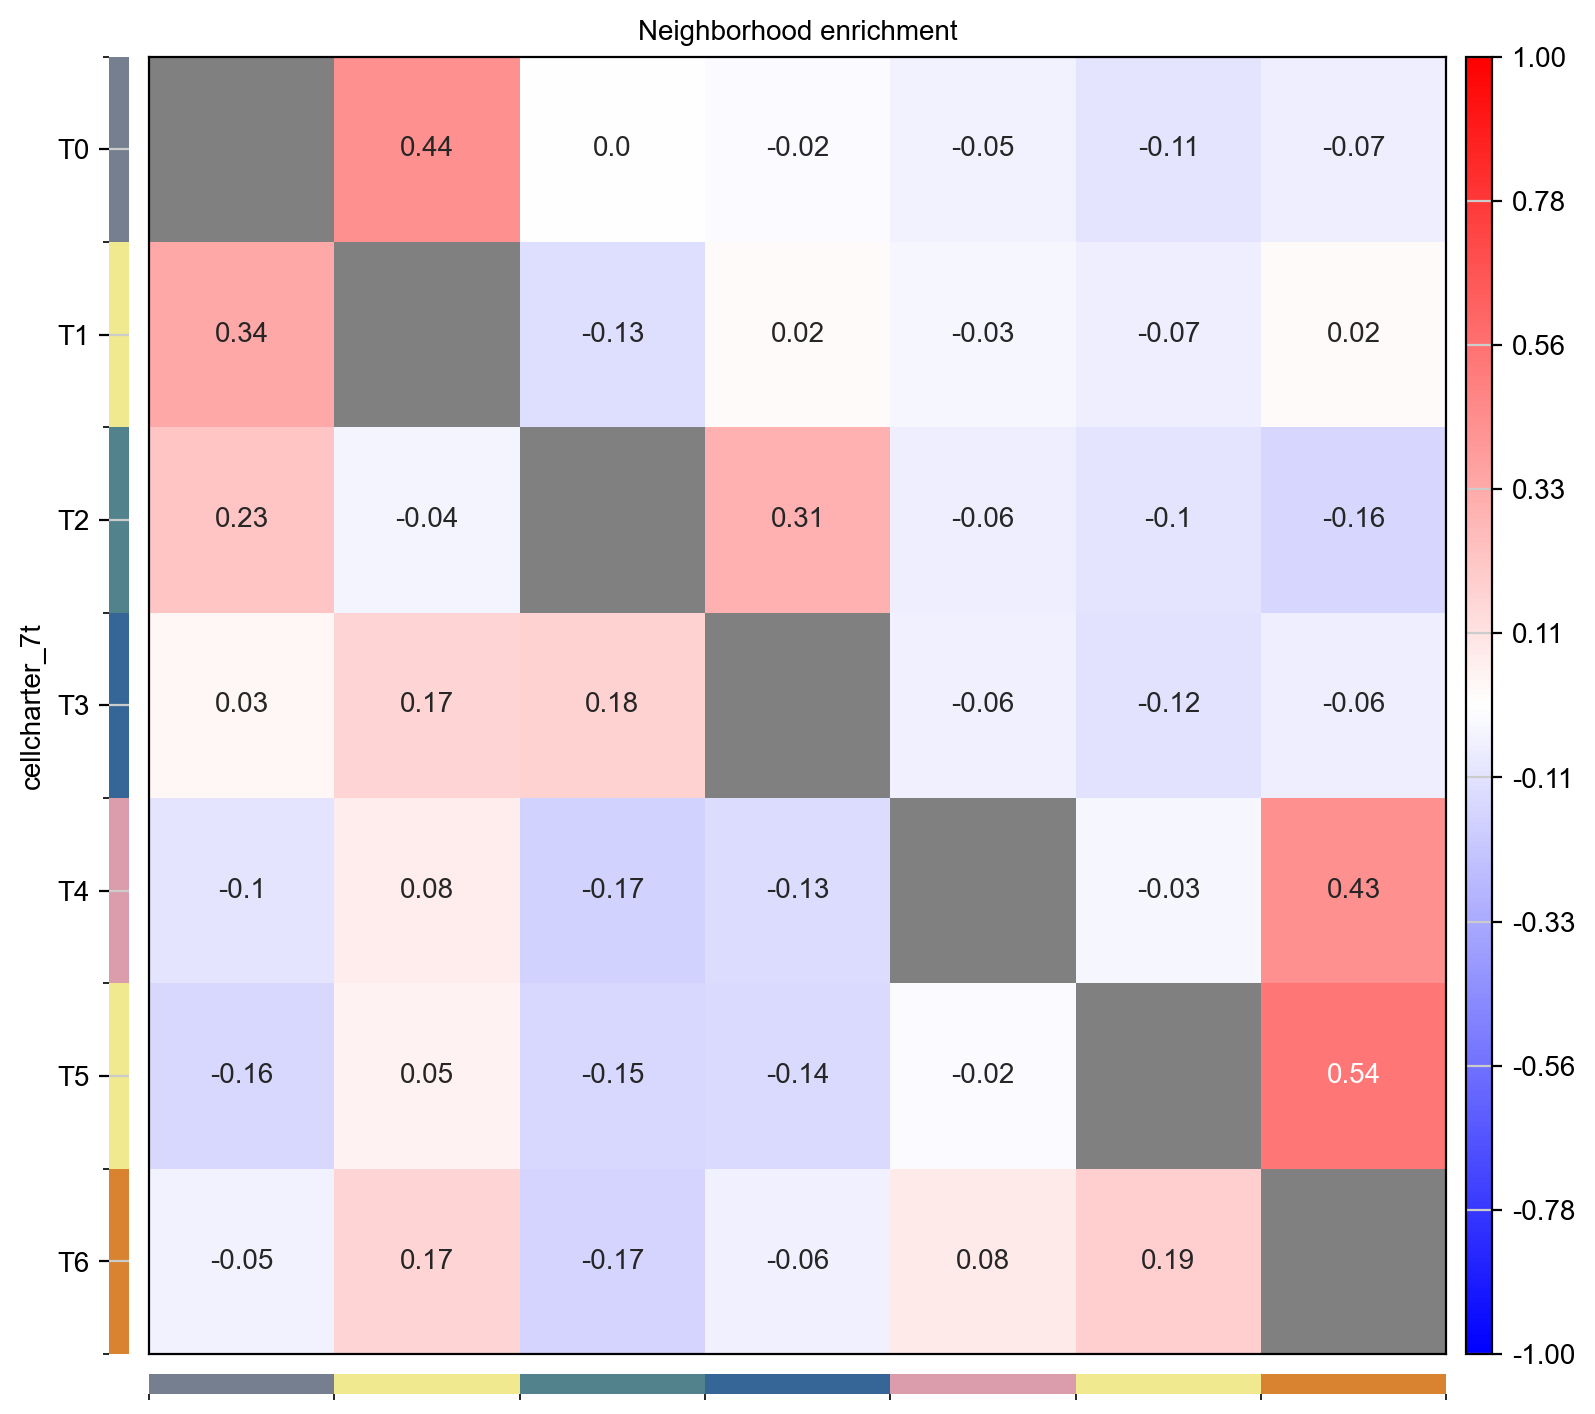

In [44]:
cc.pl.nhood_enrichment(
    data,
    cluster_key='cellcharter_7t',
    annotate=True,
    vmin=-1,
    vmax=1,palette=niche_palette,
    save='niche_neighbor.pdf'
    
)

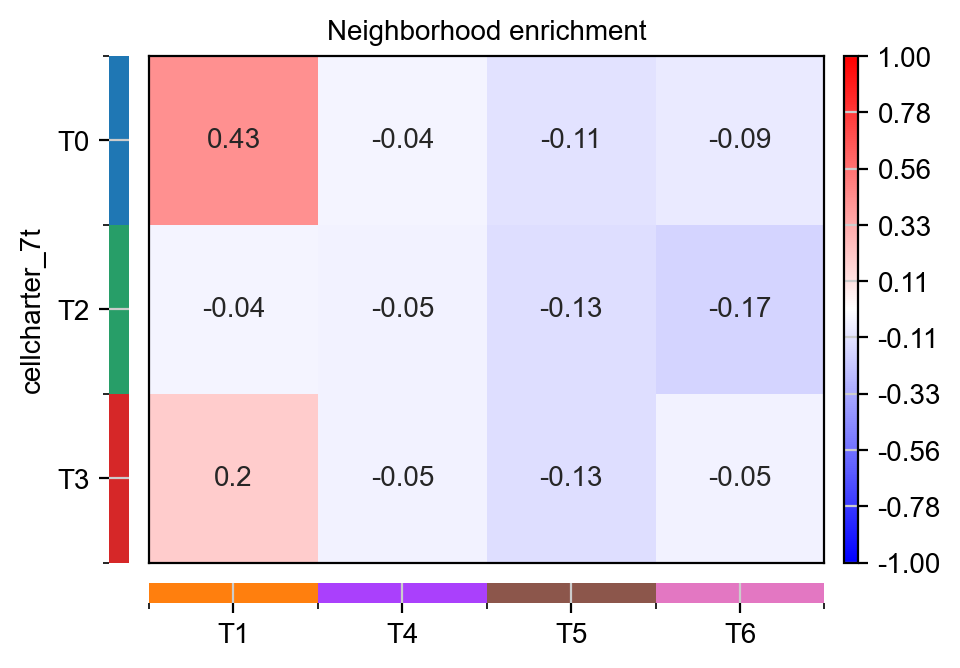

In [71]:
data_dfsy = data[data.obs['DFS'] == 'Dismal']
cc.gr.nhood_enrichment(
    data_dfsy,
    cluster_key='cellcharter_7t',
)

cc.pl.nhood_enrichment(
    data_dfsy,
    cluster_key='cellcharter_7t',
    annotate=True,
    vmin=-1,
    vmax=1, 
    row_groups=['T0','T2','T3'],
    col_groups=['T1','T4','T5','T6'], 
)

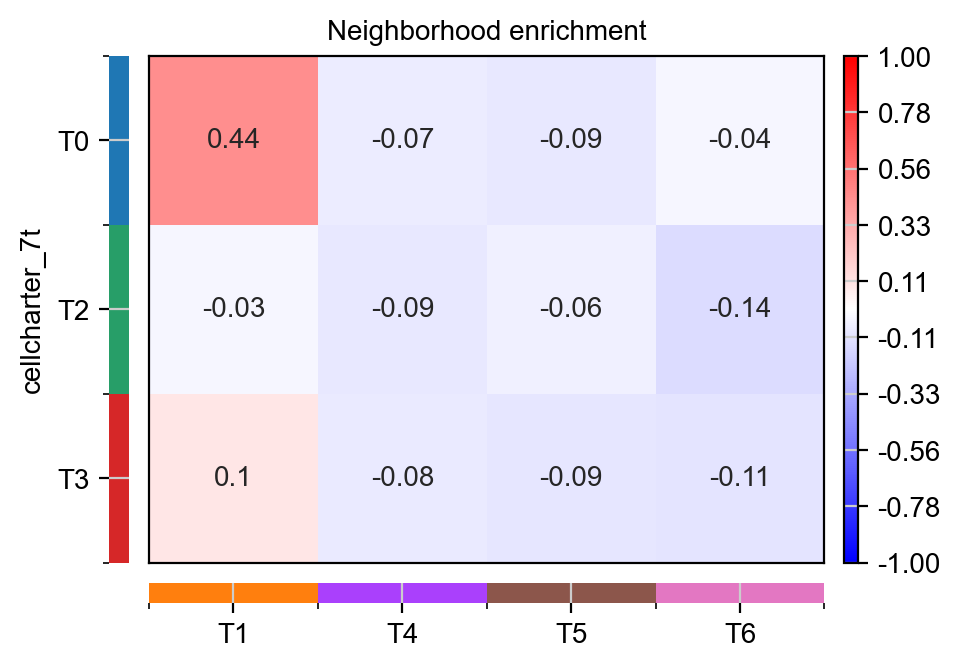

In [72]:
data_dfsn = data[data.obs['DFS'] == 'Non-dismal']
cc.gr.nhood_enrichment(
    data_dfsn,
    cluster_key='cellcharter_7t',
)

cc.pl.nhood_enrichment(
    data_dfsn,
    cluster_key='cellcharter_7t',
    annotate=True,
    vmin=-1,
    vmax=1,
    row_groups=['T0','T2','T3'],
    col_groups=['T1','T4','T5','T6'], 
    
)

In [7]:
cc.gr.diff_nhood_enrichment(
    data,
    cluster_key='cellcharter_7t',
    condition_key='DFS',
    library_key='fov_id',
    pvalues=True,
    n_jobs=15,
    n_perms=1000
)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/eunseopseo/opt/anaconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_clusters = np.array(adata.obs[cluster_key][matrix.indices])
/Users/eunseopseo/opt/anaconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs[cluster_key][np.repeat(np.arange(matrix.indptr.shape[0] - 1), np.diff(matrix.indptr))]
/Users/eunseopseo/opt/anaconda3/envs/cellcharter/lib/python3.10/site-packages/cellcharter/gr/_build.py:123: FutureWarning: Series.__getitem__ treating k

In [6]:
data.uns['cellcharter_7t_DFS_diff_nhood_enrichment']['Dismal_Non-dismal']['pvalue']

T0     T1     T2     T3     T4     T5     T6
T0  0.000  0.463  0.001  0.016  0.158  0.174  0.010
T1  0.164  0.000  0.000  0.148  0.199  0.110  0.018
T2  0.363  0.395  0.000  0.149  0.154  0.022  0.172
T3  0.122  0.030  0.357  0.000  0.163  0.169  0.052
T4  0.386  0.355  0.003  0.008  0.000  0.178  0.340
T5  0.420  0.265  0.067  0.007  0.453  0.000  0.029
T6  0.068  0.023  0.003  0.167  0.487  0.097  0.000

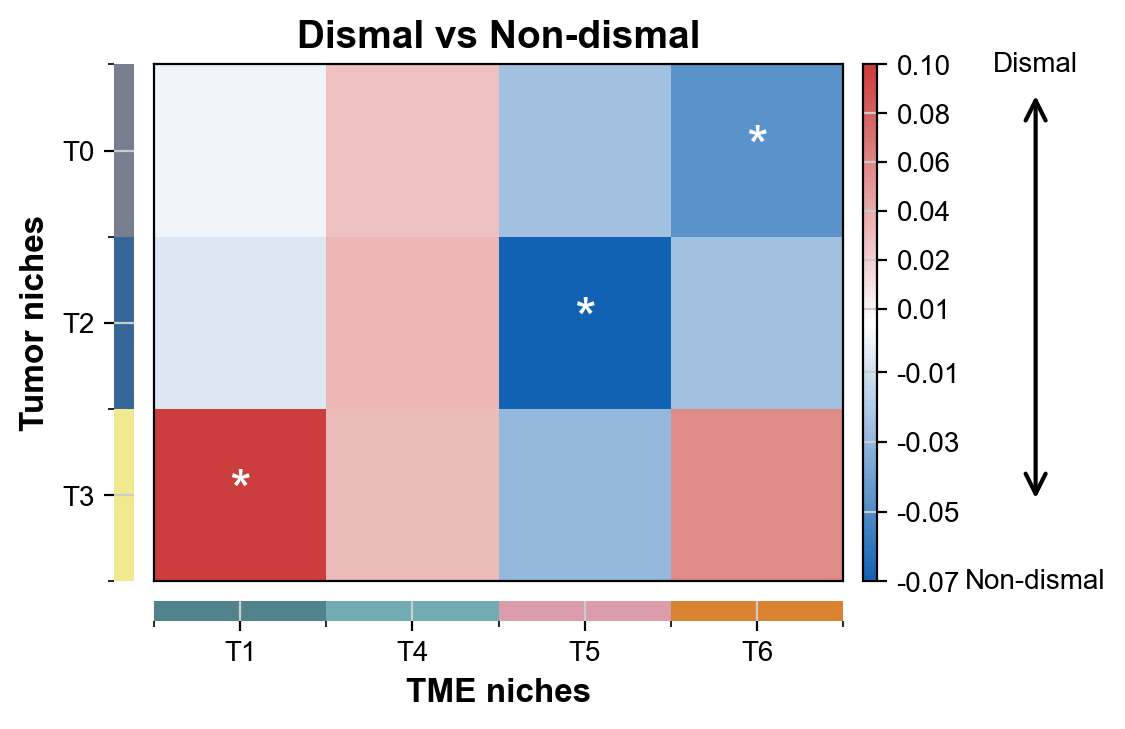

In [10]:
import cellcharter as cc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
niche_colors=['#767F8FFF','#52838CFF','#366698FF','#F0E990FF','#72ABB1FF','#DB9CABFF','#D9822FFF']
niche_palette = plt.cm.colors.ListedColormap(niche_colors)
# Assume data is your AnnData object and custom_palette is defined

# Convert DFS to categorical
data.obs['DFS'] = data.obs['DFS'].astype('category')
colors = ["#1262b3", "white", "#cc3d3d"]

# Create a colormap
colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=100)

# Generate the plot
cc.pl.diff_nhood_enrichment(
    data,
    cluster_key='cellcharter_7t',
    condition_key='DFS',    
    condition_groups=['Dismal','Non-dismal'],
    row_groups=['T0','T2','T3'],
    col_groups=['T1','T4','T5','T6'], 
    palette=niche_palette,
    annotate=True,
    figsize=(4, 4),cmap=colormap,
    significance=0.05,
    save=None  # Avoid saving for now
)

# Access the current figure and axes
fig = plt.gcf()  # Get current figure
axes = fig.get_axes()  # Get all axes from the figure
cbar = fig.axes[-1]  # The last axes is usually the colorbar

# Remove the y-axis title
cbar.set_ylabel('')

# # Remove the y-axis title for all axes
# for ax in axes:
#     ax.set_ylabel('')

main_ax = axes[1]  # Assuming the first axis is your main plot
main_ax.set_ylabel('Tumor niches',fontsize=12,fontweight='bold')

main_ax2 = axes[2]  # Assuming the first axis is your main plot

main_ax2.set_xlabel('TME niches',fontsize=12,fontweight='bold')


main_ax3 = axes[0]  # Assuming the first axis is your main plot

main_ax3.set_title('Dismal vs Non-dismal', fontsize=14,fontweight='bold')  # Increase font size for the title

# Save the modified plot
# plt.savefig('dismal1K_niche_enrich_diff_sig_no_yaxis_title.pdf')
arrow = patches.FancyArrowPatch((12.5, 0.15), (12.5, 0.95), 
                                transform=cbar.transAxes,
                                arrowstyle='<->', 
                                mutation_scale=18, 
                                color='black', 
                                linewidth=1.5)
fig.add_artist(arrow)


# Add labels for "Dismal" and "Non-dismal"
cbar.text(12.5, 1, 'Dismal', ha='center', va='center', fontsize=10, color='black', transform=cbar.transAxes)
cbar.text(12.5, 0, 'Non-dismal', ha='center', va='center', fontsize=10, color='black', transform=cbar.transAxes)

for ax in axes:
    for text in ax.texts:
        if text.get_text() == '*':
            text.set_fontsize(20)  # Set the font size for asterisks
            text.set_ha('center')  # Center align horizontally
            text.set_va('center')  # Center align vertically


plt.savefig('dismal1K_niche_enrich_diff_sig.pdf',dpi=600,bbox_inches='tight')

plt.show()
